# 0. はじめに
この notebook は、 IOAI 2025 対策サーバー第三回コンペ復習会の baseline notebook です。自作のベースラインを使わない人はこのベースラインを使ってください。  

## 0.1. このコンペについて
- いくつかの特徴量から、銀行のユーザーが解約するかどうかを予測する、テーブルデータの二値分類コンペです。
- 評価指標は [ROC-AUC](https://zenn.dev/yuto_mo/articles/3378374bc5d8f5) です。
- **今回のコンペは、 test データに対する予測結果を csv ファイルで提出するだけでいいです。手元で実行して csv ファイルを作ってもよし、 kaggle 上で作って提出してもよし、です。**  
- 非常に僅かな改善を積み重ねていくコンペなので、スコアが上がらなくても気にせず、多様なモデルやライブラリ、手法の使い方を積極的に試していってください！

## 0.2. 今回の目標
- 初心者 : テーブルコンペの基礎を学ぶ
- 中級者、上級者 : できるだけ高いスコアを取る。様々な手法を試す。

## 0.3. データについて
- train.csv, test.csv, submission.csv という 3 つのファイルが与えられます。
- train.csv の "Existed" という列が目的変数です。

## 0.4. コンペ復習会について
- 解く時は基本的に自由にやってもらって大丈夫です。ただし、 IOAI に近い形式にするなら検索 OK 、このコンペの notebook と discussion は参考にしない、とかがいいと思います。
- 解く期間の終了日は 2/5 です。その後、上位陣の解法を見たり、それぞれの解法を見たりします。一つの google slide をみんなで編集する予定です。  

## 0.5. その他
- 何でもわからないところがあったらどんどん質問してください！
- 一部説明はテーブルデータコンペの基本的な知識があることを前提に書かれています。わからない所があれば適宜調べるか質問してください。
- 初心者じゃない人へ : 一部記述がおかしかったりしたら指摘してくださるとありがたいです！

# 1. ライブラリ読み込みと設定

In [35]:
import os
import time 
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

import lightgbm as lgb


def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [36]:
class CFG :
    debug = False
    random_seed = 42
    n_splits = 5
    num_classes = 2
    target = "Exited"
    drop_col = ["id", "CustomerId", "Surname"]
    cat_col = ["Geography", "Gender"]
    data_dir = "../input/"
    exp_name = "lgbm_baseline"

今回は lightgbm 用の設定をまとめます。ハイパラは途中から一部のパラメータのデフォルトの値を入れてあるので各自で調べていじってみてください！  


In [37]:
class lgbm_CFG : 
    # ここらへんは変えない方がいいかも？
    print_freq = 100 # 何ラウンドごとに評価するか
    num_rounds = 10000 # 何ラウンド回すか、大きめの値を入れておいて早期終了する
    early_stopping_rounds = 100 # 何ラウンド改善がなかったら終了するか
    metric = "auc" # 評価指標
    objective = "binary" # 二値分類なので
    boosting = "gbdt" # 今回は gbdt というブースティング手法を使います
    
    # ここからはデフォルトの値を入れてます！
    learning_rate = 0.1
    max_depth = -1
    num_leaves = 31
    min_data_in_leaf = 20
    bagging_fraction = 1.0
    bagging_freq = 0
    feature_fraction = 1.0
    lambda_l1 = 0.0
    lambda_l2 = 0.0


# 2. データの形式を確認しよう

In [38]:
train_df = pd.read_csv(os.path.join(CFG.data_dir, "playground-series-s4e1", "train.csv"))
test_df = pd.read_csv(os.path.join(CFG.data_dir, "playground-series-s4e1", "test.csv"))
sub = pd.read_csv(os.path.join(CFG.data_dir, "playground-series-s4e1", "sample_submission.csv"))
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


# 3. 簡単な EDA をしよう
EDA というのは、調ざっくり言うとデータの可視化などの手法で、データの性質を調べていこう、という手法です


In [39]:
# EDA
print(train_df.shape)
print(test_df.shape)

(165034, 14)
(110023, 13)


In [40]:
# 欠損値の確認
print(train_df.isnull().sum())

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


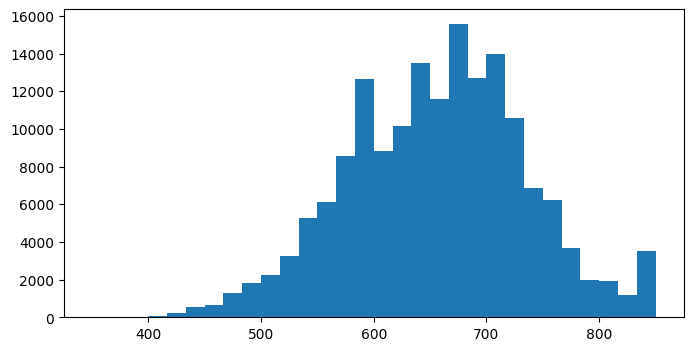

In [41]:
# CreditScore の分布    
plt.figure(figsize=(8, 4))
plt.hist(train_df["CreditScore"], bins=30)
plt.show()

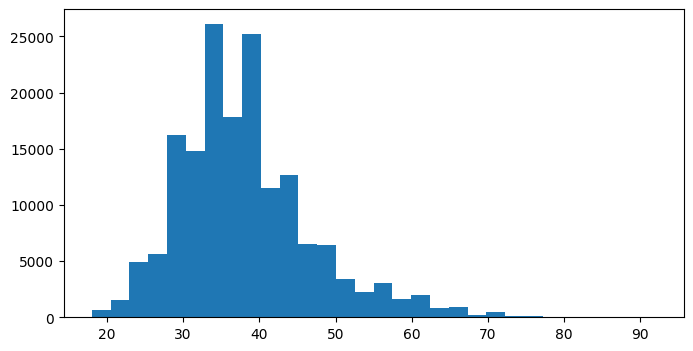

In [42]:
# Age の分布
plt.figure(figsize=(8, 4))
plt.hist(train_df["Age"], bins=30)
plt.show()


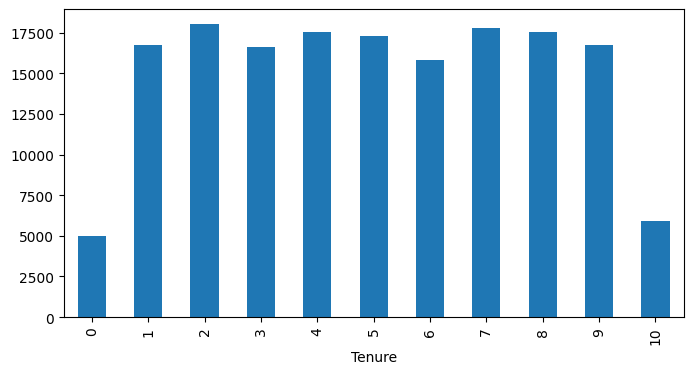

In [43]:
# Tenure の分布、棒グラフで表示
plt.figure(figsize=(8, 4))
train_df["Tenure"].value_counts().sort_index().plot(kind="bar")
plt.show()


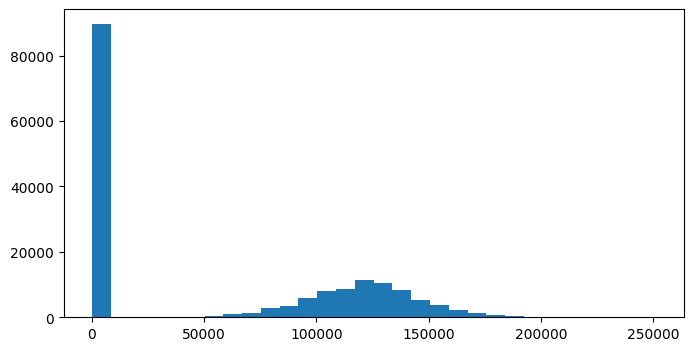

In [44]:
# Balance の分布
plt.figure(figsize=(8, 4))
plt.hist(train_df["Balance"], bins=30)
plt.show()


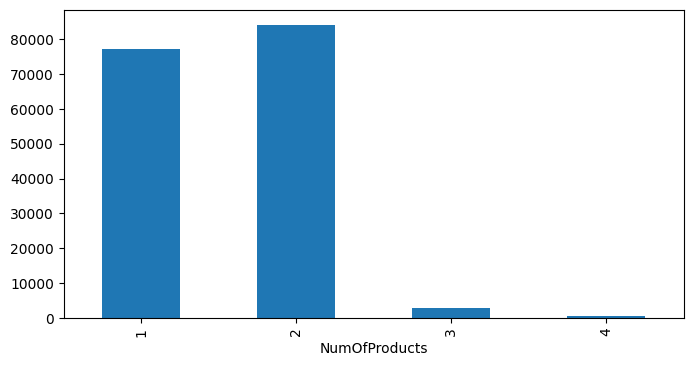

In [45]:
# NumOfProducts の分布、棒グラフで表示、横軸は数字の大きさ順に並べる
plt.figure(figsize=(8, 4))
train_df["NumOfProducts"].value_counts().sort_index().plot(kind="bar")
plt.show()

残りの変数についても、適切な可視化を考えてみましょう！

# 4. 特徴量エンジニアリングをしよう
テーブルデータでは、数値と数値、数値とカテゴリ、カテゴリとカテゴリなど特徴量の組み合わせで新しい特徴量を作ることがあります。これを入力することで、モデルの精度が向上することがあります。

以下のセルに特徴量エンジニアリングを追加してみましょう。

In [46]:
def process_data(df, is_train=True) :
    df = df.drop(CFG.drop_col, axis=1)
    for col in CFG.cat_col :
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    
    # ここに特徴量エンジニアリングを追加する。ここでは例として is_balance_zero を追加している
    df["is_balance_zero"] = (df["Balance"] == 0).astype(int)
    
    if is_train :
        return df.drop(CFG.target, axis=1), df[CFG.target]
    else :
        return df

In [47]:
train_df, train_target = process_data(train_df)
test_df = process_data(test_df, is_train=False)

# 5. CV を組もう
今までやってきたとおりです。今回は目的変数の分布にやや偏りがあるので StratifiedKFold を用います。

In [48]:
def train_lgbm_one_fold(X_train, y_train, X_valid, y_valid, X_test, params, fold_id) :
    print(f"====================training fold {fold_id}====================")
    # lightgbm 用のデータセットに変換する
    train = lgb.Dataset(X_train, label=y_train)
    valid = lgb.Dataset(X_valid, label=y_valid)
    
    # モデルの学習、valid を監視して early stopping する
    model = lgb.train(
        params=params,
        train_set=train,
        num_boost_round=lgbm_CFG.num_rounds,
        valid_sets=[train, valid],
        valid_names=["train", "valid"],
        callbacks=[lgb.early_stopping(lgbm_CFG.early_stopping_rounds, verbose=True), lgb.log_evaluation(period=lgbm_CFG.print_freq)],
    )
    
    # oof の結果を返す
    oof = model.predict(X_valid)
    score = roc_auc_score(y_valid, oof)
    print(f"fold {fold_id} roc-auc: {score}")
    
    test_preds = model.predict(X_test)
    return oof, test_preds, model

In [49]:
def train_lgbm(X, y, test, params) :
    # oof の結果も返す
    oof_preds = np.zeros((X.shape[0], ))
    test_preds = np.zeros((test.shape[0], ))
    
    skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.random_seed)
    for fold_id, (train_index, valid_index) in enumerate(skf.split(X, y)) :
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        oof, test_preds, _ = train_lgbm_one_fold(X_train, y_train, X_valid, y_valid, test, params, fold_id)
        
        oof_preds[valid_index] = oof
        test_preds += test_preds / CFG.n_splits
    
    score = roc_auc_score(y, oof_preds)
    print(f"total roc-auc: {score}")
    
    return oof, test_preds

In [50]:
# ここでは、 lightgbm に渡すパラメータを定義
params = {
    "objective" : "binary",
    "metric" : lgbm_CFG.metric,
    "verbosity" : -1,
    "boosting_type" : lgbm_CFG.boosting,
    # "device_type" : "gpu", # 結果の一意性が保証されないためコメントアウト
    "random_state" : CFG.random_seed,
    # CFG デフォルト値につき以下省略。書きたい場合は上の書き方を参考にして記入してください。
}

In [51]:
def main() :
    oof, test_preds = train_lgbm(train_df, train_target, test_df, params)
    sub[CFG.target] = test_preds
    sub.to_csv(f"submission_{CFG.exp_name}.csv", index=False)
    
if __name__ == "__main__" :
    main()

====================training fold 0====================
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.897866	valid's auc: 0.88936
[200]	train's auc: 0.905809	valid's auc: 0.889422
Early stopping, best iteration is:
[131]	train's auc: 0.900516	valid's auc: 0.889558
fold 0 roc-auc: 0.8895576926860762
====================training fold 1====================
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.897846	valid's auc: 0.88875
[200]	train's auc: 0.905539	valid's auc: 0.888628
Early stopping, best iteration is:
[100]	train's auc: 0.897846	valid's auc: 0.88875
fold 1 roc-auc: 0.8887495477720629
====================training fold 2====================
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.897076	valid's auc: 0.890691
[200]	train's auc: 0.905465	valid's auc: 0.890731
Early stopping, best iteration is:
[161]	train's auc: 0.902371	valid's auc: 0.890812
fold 2 roc-auc: 0.890811

# 6. 改善ポイント
- 特徴量エンジニアリングをやろう (全員) : 特徴量エンジニアリングをやりましょう。正規化とかするだけでも結果は変わってきます。 [この記事](https://zenn.dev/colum2131/articles/fffac4654e7c7c) に基本的なことはまとまっているので、読んでみてください！    
- ハイパラ調整をしよう（全員） : パラメータはデフォルトの値よりもいい値が存在することが多いです。 [この記事](https://zenn.dev/mosamosa/articles/07d0076c9292136a3639) を読んで手動で探索してもいいですし、 **optuna** というライブラリを使うととっても楽に出来るので調べてみましょう！
- アンサンブルをしよう（全員） : lightgbm と似たような手法だと xgboost などの有名ライブラリがあります。 それ以外にも、普通に NN を実装したり、ロジスティクス回帰などの少し性質の異なるアルゴリズムをアンサンブルに入れたりすると良いでしょう！
- 実験管理を気をつけよう（中級者） : 1notebook 1 実験を心がけるとやりやすいです
- スタッキングをしよう（中級者） : スタッキングをしましょう。